In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
# Load the processed dataset
df_clean = pd.read_csv('churn_processed.csv')

# Separate features and target
X = df_clean.drop('Exited', axis=1)
y = df_clean['Exited']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (7000, 14)
Test set shape: (3000, 14)


In [3]:
# Build a decision tree with default settings
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [4]:
# Evaluate on training and test sets
y_train_pred = dt_default.predict(X_train)
y_test_pred = dt_default.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nDefault Decision Tree Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Default Decision Tree Performance:
Training Accuracy: 0.9997
Test Accuracy: 0.9417


In [5]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_default.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances.head(10))


Feature Importances:
             Feature  Importance
7   ComplaintsLodged    0.831229
10   EstimatedSalary    0.034434
2                Age    0.032082
0        CreditScore    0.031932
5            Balance    0.030601
4             Tenure    0.014164
6      NumOfProducts    0.010609
8          HasCrCard    0.003777
1                Sex    0.002801
9     IsActiveMember    0.002553


In [6]:
# Get tree information
n_nodes = dt_default.tree_.node_count
n_leaves = dt_default.tree_.n_leaves
max_depth = dt_default.tree_.max_depth

print("\nTree Information:")
print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")
print(f"Number of rules: {n_leaves}")  # Each leaf corresponds to a decision rule
print(f"Maximum depth: {max_depth}")


Tree Information:
Number of nodes: 583
Number of leaves: 292
Number of rules: 292
Maximum depth: 17


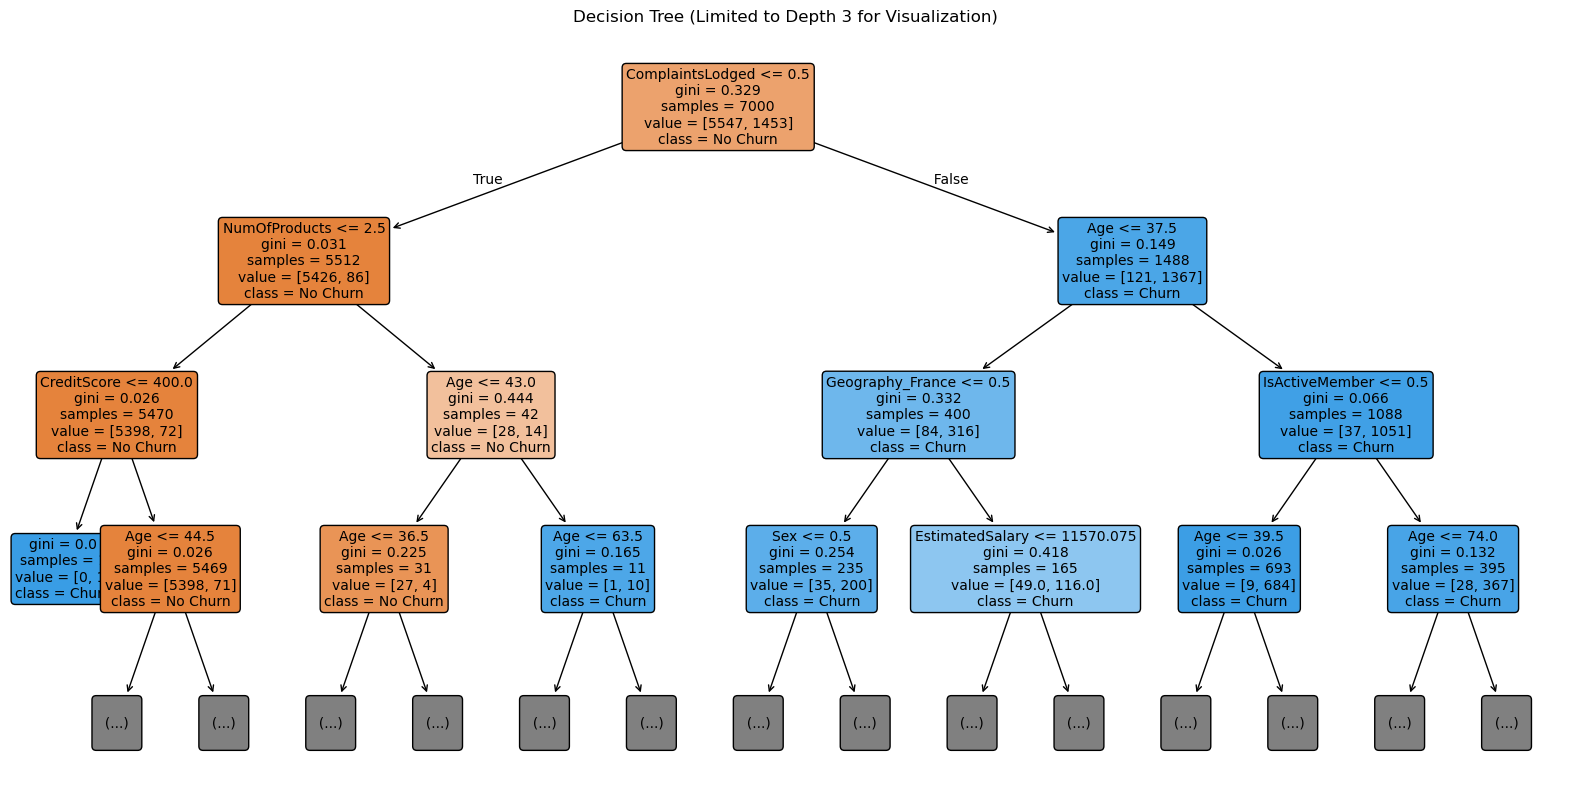

In [7]:
# Plot the decision tree (limited to max_depth=3 for visualization)
plt.figure(figsize=(20, 10))
plot_tree(dt_default, max_depth=3, feature_names=X.columns, class_names=['No Churn', 'Churn'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree (Limited to Depth 3 for Visualization)")
plt.show()

In [8]:
# Get the first split feature
first_split_feature = X.columns[dt_default.tree_.feature[0]]
print(f"\nFirst split feature: {first_split_feature}")

# Get the second split features (there can be two second splits)
left_child_idx = dt_default.tree_.children_left[0]
right_child_idx = dt_default.tree_.children_right[0]
left_split_feature = X.columns[dt_default.tree_.feature[left_child_idx]] if left_child_idx != -1 else "None"
right_split_feature = X.columns[dt_default.tree_.feature[right_child_idx]] if right_child_idx != -1 else "None"

print(f"Second split features: {left_split_feature} (left branch) and {right_split_feature} (right branch)")



First split feature: ComplaintsLodged
Second split features: NumOfProducts (left branch) and Age (right branch)


In [9]:
# Check for overfitting by comparing training and test accuracy
print("\nOverfitting Check:")
print(f"Accuracy difference (Train - Test): {train_accuracy - test_accuracy:.4f}")
if train_accuracy - test_accuracy > 0.05:
    print("Possible overfitting: Training accuracy is higher than test accuracy")
else:
    print("No strong evidence of overfitting: Training and test accuracies are similar")


Overfitting Check:
Accuracy difference (Train - Test): 0.0580
Possible overfitting: Training accuracy is higher than test accuracy


In [10]:
# Explanation of hyperparameters:
# - max_depth: Maximum depth of the tree (None means unlimited)
# - min_samples_split: Minimum samples required to split a node
# - min_samples_leaf: Minimum samples required at a leaf node
# - criterion: Function to measure the quality of a split (gini or entropy)

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

In [28]:
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',      # Use accuracy as the scoring metric
    n_jobs=-1,               # Use all available CPU cores
    verbose=1                # Show progress
)

In [30]:
# Perform the grid search
print("Starting Grid Search for Decision Tree optimization...")
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
print("\nBest Parameters:")
print(grid_search.best_params_)

# Use the best model
dt_best = grid_search.best_estimator_

Starting Grid Search for Decision Tree optimization...
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Parameters:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [32]:
# Evaluate on training and test sets
y_train_pred_best = dt_best.predict(X_train)
y_test_pred_best = dt_best.predict(X_test)

train_accuracy_best = accuracy_score(y_train, y_train_pred_best)
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)

print("\nOptimized Decision Tree Performance:")
print(f"Training Accuracy: {train_accuracy_best:.4f}")
print(f"Test Accuracy: {test_accuracy_best:.4f}")


Optimized Decision Tree Performance:
Training Accuracy: 0.9717
Test Accuracy: 0.9653


In [34]:
# Get feature importances
feature_importances_best = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances_best.head(10))


Feature Importances:
                Feature  Importance
7      ComplaintsLodged    0.951731
2                   Age    0.022453
6         NumOfProducts    0.021485
9        IsActiveMember    0.004330
0           CreditScore    0.000000
1                   Sex    0.000000
3  CurrentWorkingStatus    0.000000
4                Tenure    0.000000
5               Balance    0.000000
8             HasCrCard    0.000000


In [36]:
# Get tree information
n_nodes_best = dt_best.tree_.node_count
n_leaves_best = dt_best.tree_.n_leaves
max_depth_best = dt_best.tree_.max_depth

print("\nTree Information:")
print(f"Number of nodes: {n_nodes_best}")
print(f"Number of leaves: {n_leaves_best}")
print(f"Number of rules: {n_leaves_best}")  # Each leaf corresponds to a decision rule
print(f"Maximum depth: {max_depth_best}")


Tree Information:
Number of nodes: 15
Number of leaves: 8
Number of rules: 8
Maximum depth: 3


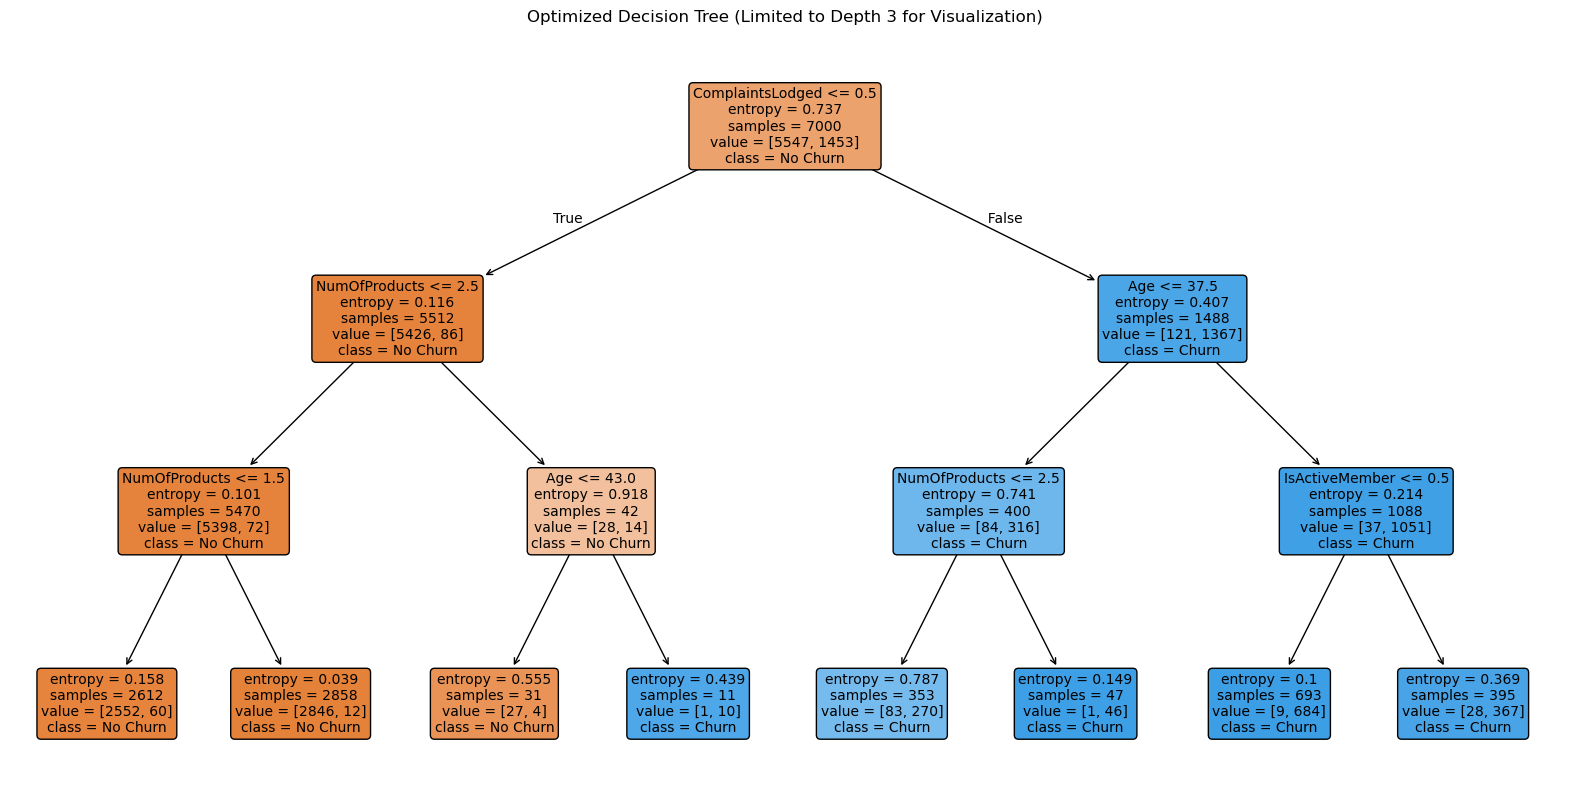

In [38]:
# Plot the decision tree (limited to max_depth=3 for visualization)
plt.figure(figsize=(20, 10))
plot_tree(dt_best, max_depth=3, feature_names=X.columns, class_names=['No Churn', 'Churn'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Optimized Decision Tree (Limited to Depth 3 for Visualization)")
plt.show()


In [40]:
# Get the first split feature
first_split_feature_best = X.columns[dt_best.tree_.feature[0]]
print(f"\nFirst split feature: {first_split_feature_best}")

# Get the second split features (there can be two second splits)
left_child_idx_best = dt_best.tree_.children_left[0]
right_child_idx_best = dt_best.tree_.children_right[0]
left_split_feature_best = X.columns[dt_best.tree_.feature[left_child_idx_best]] if left_child_idx_best != -1 else "None"
right_split_feature_best = X.columns[dt_best.tree_.feature[right_child_idx_best]] if right_child_idx_best != -1 else "None"

print(f"Second split features: {left_split_feature_best} (left branch) and {right_split_feature_best} (right branch)")



First split feature: ComplaintsLodged
Second split features: NumOfProducts (left branch) and Age (right branch)


In [42]:
# Check for overfitting by comparing training and test accuracy
print("\nOverfitting Check:")
print(f"Accuracy difference (Train - Test): {train_accuracy_best - test_accuracy_best:.4f}")
if train_accuracy_best - test_accuracy_best > 0.05:
    print("Possible overfitting: Training accuracy is significantly higher than test accuracy")
else:
    print("No strong evidence of overfitting: Training and test accuracies are similar")


Overfitting Check:
Accuracy difference (Train - Test): 0.0064
No strong evidence of overfitting: Training and test accuracies are similar


In [44]:
y_test_proba_default = dt_default.predict_proba(X_test)[:, 1]
y_test_proba_best = dt_best.predict_proba(X_test)[:, 1]

In [46]:
# Calculate ROC curve and AUC for both models
fpr_default, tpr_default, _ = roc_curve(y_test, y_test_proba_default)
fpr_best, tpr_best, _ = roc_curve(y_test, y_test_proba_best)
roc_auc_default = auc(fpr_default, tpr_default)
roc_auc_best = auc(fpr_best, tpr_best)

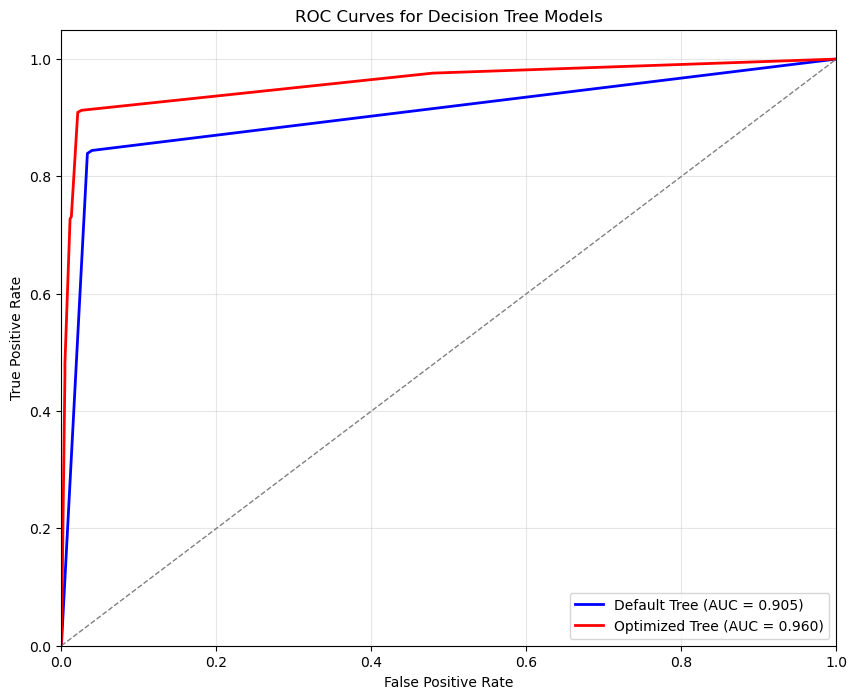

In [48]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_default, tpr_default, color='blue', lw=2, 
         label=f'Default Tree (AUC = {roc_auc_default:.3f})')
plt.plot(fpr_best, tpr_best, color='red', lw=2, 
         label=f'Optimized Tree (AUC = {roc_auc_best:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

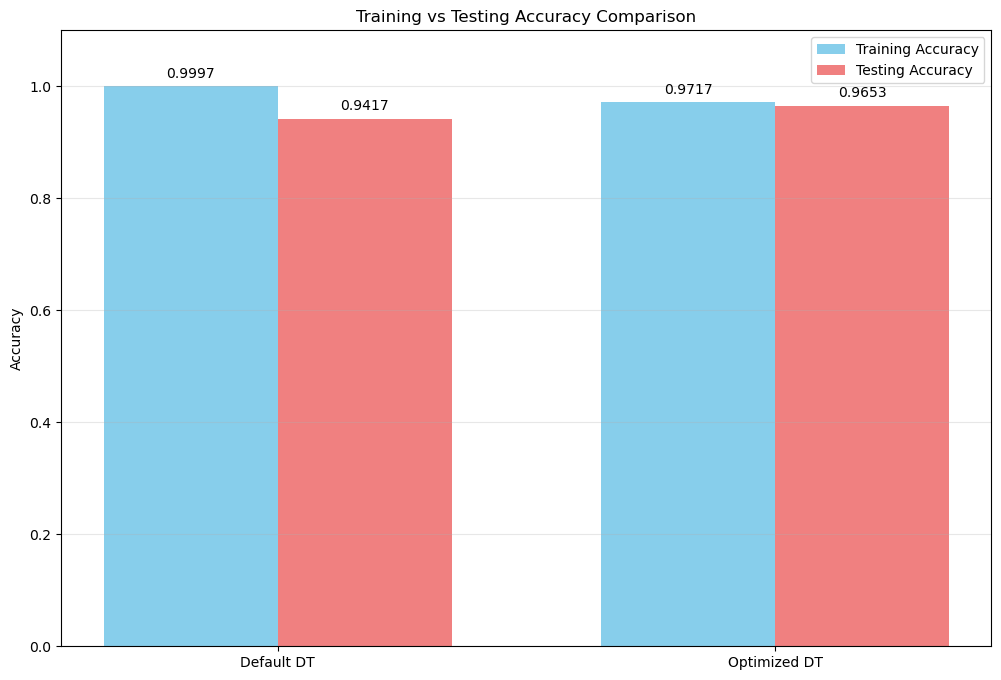

In [50]:
# Visualize training vs testing accuracy comparison
models = ['Default DT', 'Optimized DT']
train_accuracies = [train_accuracy, train_accuracy_best]
test_accuracies = [test_accuracy, test_accuracy_best]

plt.figure(figsize=(12, 8))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='skyblue')
plt.bar(x + width/2, test_accuracies, width, label='Testing Accuracy', color='lightcoral')

# Add accuracy values on bars
for i, v in enumerate(train_accuracies):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
for i, v in enumerate(test_accuracies):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy Comparison')
plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

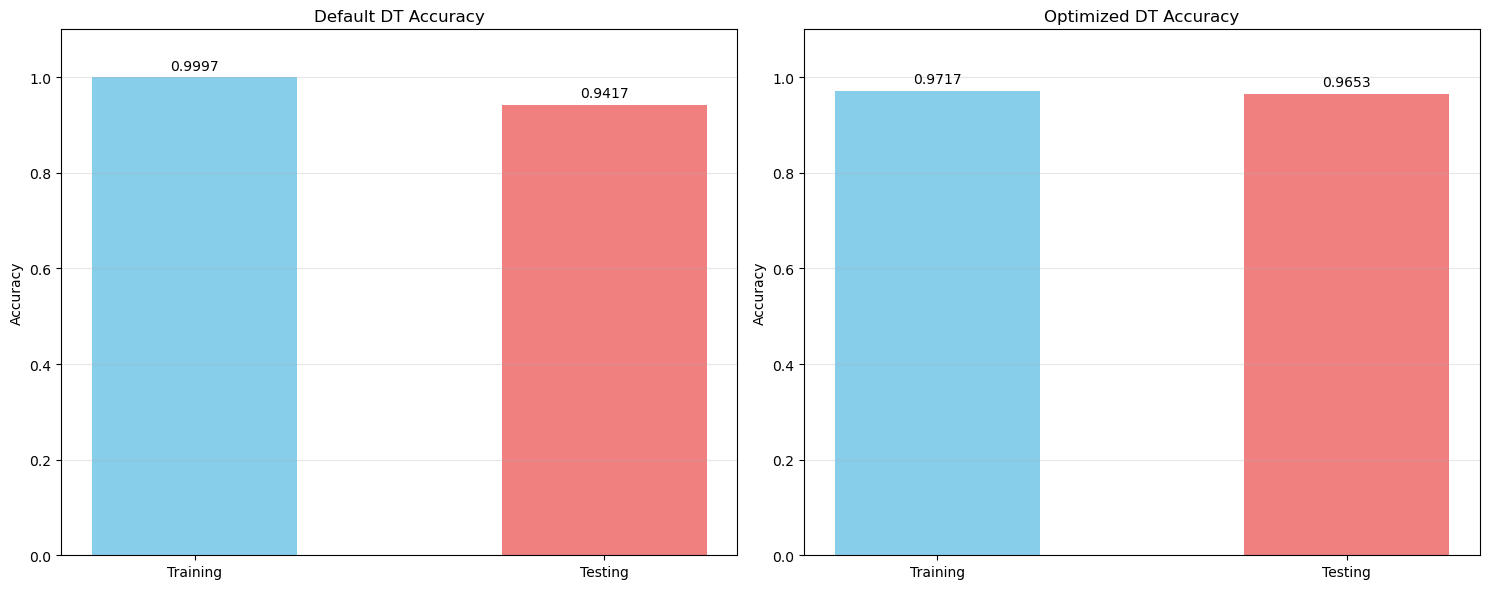

In [52]:
# Visualize training vs testing accuracy individually for each model
models = ['Default DT', 'Optimized DT']
train_accuracies = [train_accuracy, train_accuracy_best]
test_accuracies = [test_accuracy, test_accuracy_best]

plt.figure(figsize=(15, 6))

# Loop through each model and create a separate subplot
for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)  # Create side-by-side subplots
    
    # Create data for this model only
    categories = ['Training', 'Testing']
    accuracies = [train_accuracies[i], test_accuracies[i]]
    colors = ['skyblue', 'lightcoral']
    
    # Create bar chart
    bars = plt.bar(categories, accuracies, color=colors, width=0.5)
    
    # Add accuracy values on bars
    for bar, value in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, value + 0.01, 
                f'{value:.4f}', ha='center', va='bottom')
    
    # Add labels and title
    plt.ylabel('Accuracy')
    plt.title(f'{model} Accuracy')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

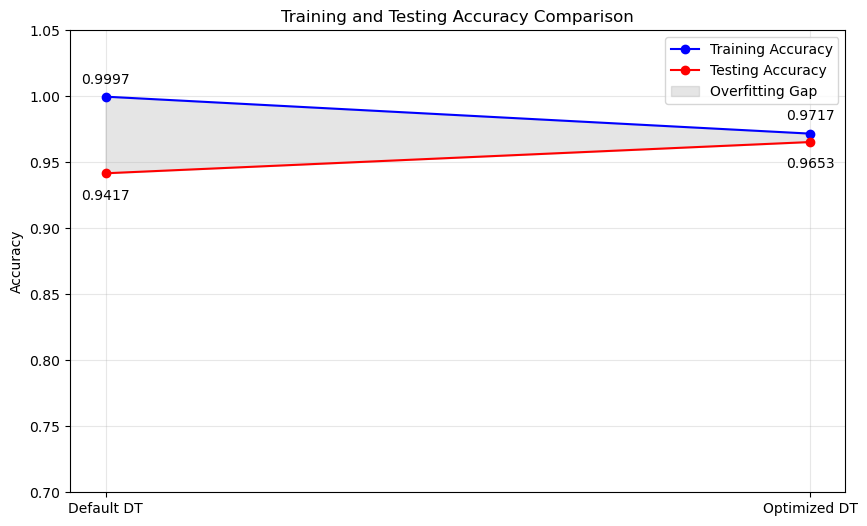

In [54]:
# Alternative visualization using a grouped line chart
plt.figure(figsize=(10, 6))
models = ['Default DT', 'Optimized DT']
x = np.arange(len(models))

# Plot lines connecting training and testing points for each model
plt.plot([0, 1], [train_accuracy, train_accuracy_best], 'o-', color='blue', label='Training Accuracy')
plt.plot([0, 1], [test_accuracy, test_accuracy_best], 'o-', color='red', label='Testing Accuracy')

# Add shaded area to highlight the gap (overfitting)
plt.fill_between([0, 1], 
                 [train_accuracy, train_accuracy_best],
                 [test_accuracy, test_accuracy_best], 
                 alpha=0.2, color='gray', label='Overfitting Gap')

# Add data points and labels
for i, (train_acc, test_acc) in enumerate(zip([train_accuracy, train_accuracy_best], 
                                              [test_accuracy, test_accuracy_best])):
    plt.text(i, train_acc + 0.01, f'{train_acc:.4f}', ha='center')
    plt.text(i, test_acc - 0.02, f'{test_acc:.4f}', ha='center')

plt.xticks([0, 1], models)
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Comparison')
plt.ylim(0.7, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

C:\Users\vaish\AppData\Local\Temp\ipykernel_44980\3360547174.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features_default, palette='Blues_d')


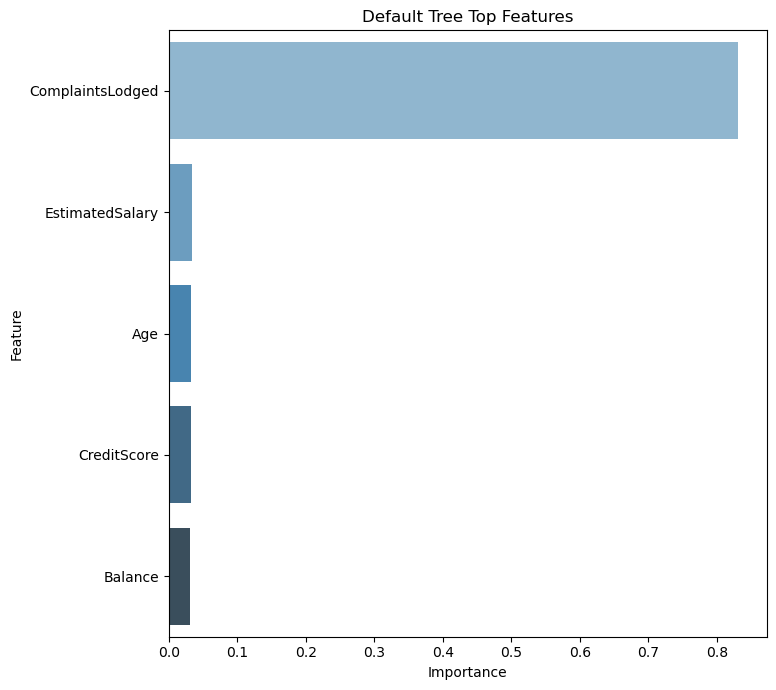

In [56]:
# Visualize feature importance comparison
plt.figure(figsize=(14, 7))

# Get top 7 features for cleaner visualization
top_features_default = feature_importances.head(5)
top_features_best = feature_importances_best.head(5)

# Create subplot for default tree feature importance
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=top_features_default, palette='Blues_d')
plt.title('Default Tree Top Features')
plt.xlabel('Importance')
plt.tight_layout()

C:\Users\vaish\AppData\Local\Temp\ipykernel_44980\686106583.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features_best, palette='Blues_d')


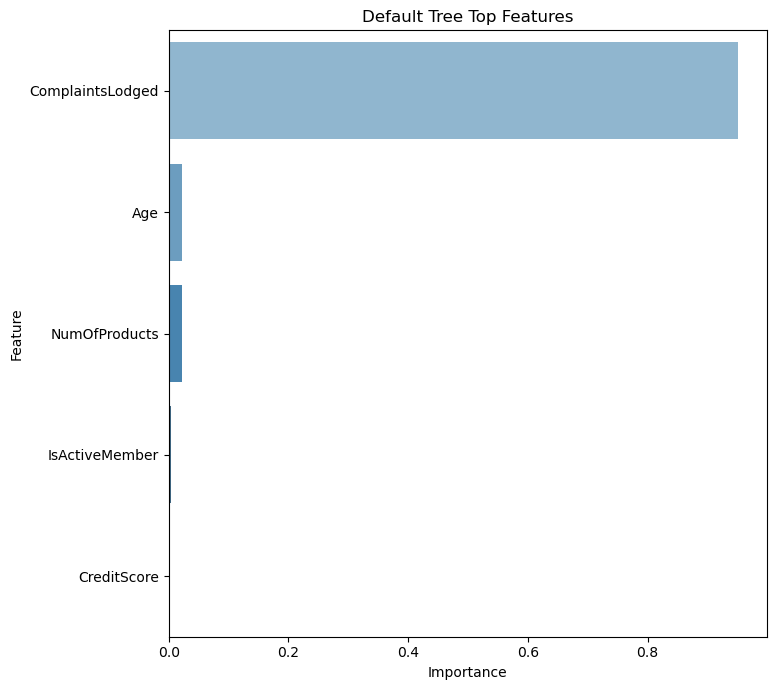

In [58]:
# Visualize feature importance comparison
plt.figure(figsize=(14, 7))

# Get top 7 features for cleaner visualization
top_features_default = feature_importances.head(5)
top_features_best = feature_importances_best.head(5)

# Create subplot for default tree feature importance
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=top_features_best, palette='Blues_d')
plt.title('Default Tree Top Features')
plt.xlabel('Importance')
plt.tight_layout()

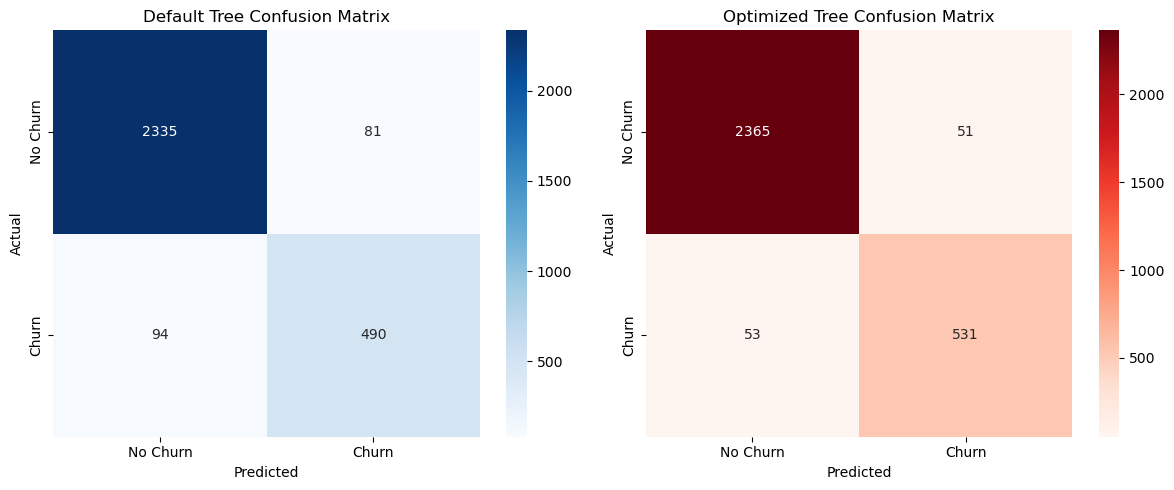

In [60]:
# Create confusion matrices for visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Default tree confusion matrix
cm1 = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Default Tree Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['No Churn', 'Churn'])
ax1.set_yticklabels(['No Churn', 'Churn'])

# Optimized tree confusion matrix
cm2 = confusion_matrix(y_test, y_test_pred_best)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds', ax=ax2)
ax2.set_title('Optimized Tree Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(['No Churn', 'Churn'])
ax2.set_yticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()


Classification Report - Default Decision Tree:
              precision    recall  f1-score   support

    No Churn       0.96      0.97      0.96      2416
       Churn       0.86      0.84      0.85       584

    accuracy                           0.94      3000
   macro avg       0.91      0.90      0.91      3000
weighted avg       0.94      0.94      0.94      3000


Classification Report - Optimized Decision Tree:
              precision    recall  f1-score   support

    No Churn       0.98      0.98      0.98      2416
       Churn       0.91      0.91      0.91       584

    accuracy                           0.97      3000
   macro avg       0.95      0.94      0.94      3000
weighted avg       0.97      0.97      0.97      3000



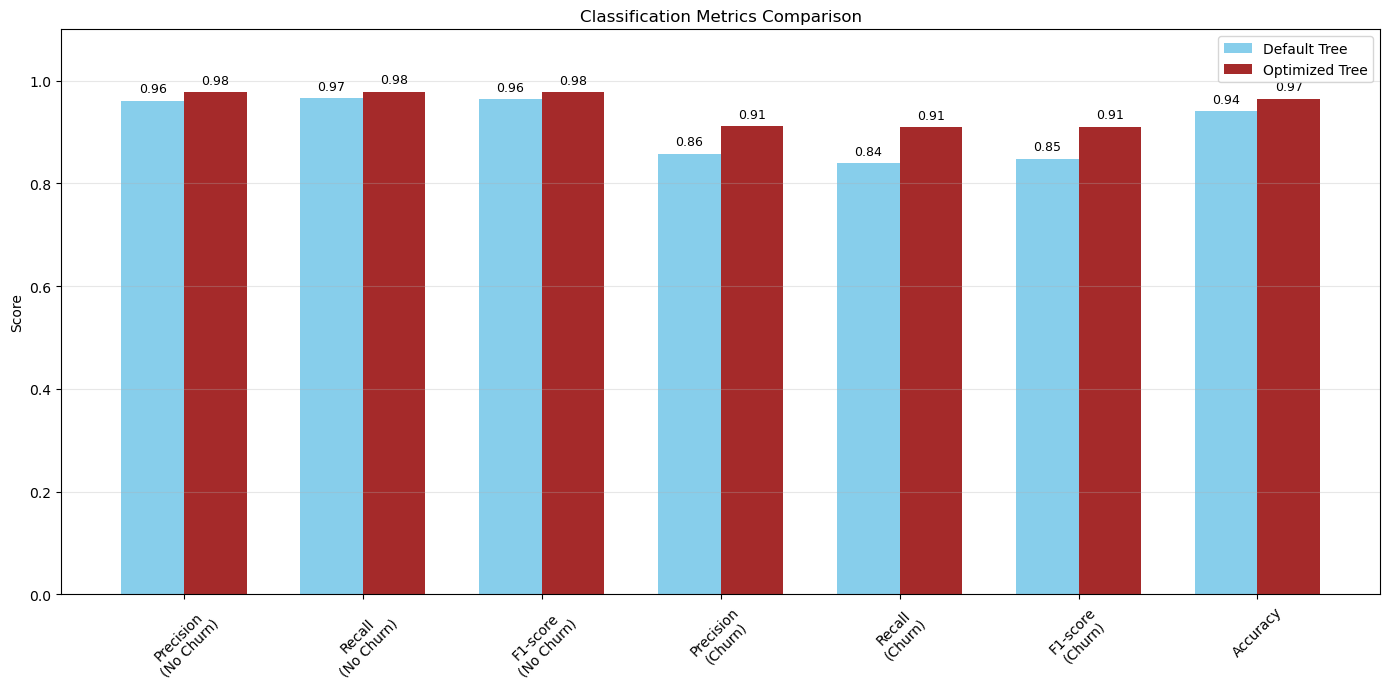

In [62]:
# Generate classification reports for both trees
from sklearn.metrics import classification_report

# Default tree classification report
print("\nClassification Report - Default Decision Tree:")
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

# Optimized tree classification report
print("\nClassification Report - Optimized Decision Tree:")
print(classification_report(y_test, y_test_pred_best, target_names=['No Churn', 'Churn']))

# Visualize classification metrics for both models
# Extract metrics from classification reports
def get_metrics_from_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']
    accuracy = report['accuracy']
    return [precision_0, recall_0, f1_0, precision_1, recall_1, f1_1, accuracy]

# Get metrics for both models
metrics_default = get_metrics_from_report(y_test, y_test_pred)
metrics_best = get_metrics_from_report(y_test, y_test_pred_best)

# Create a comparison chart
metrics_names = ['Precision\n(No Churn)', 'Recall\n(No Churn)', 'F1-score\n(No Churn)', 
                'Precision\n(Churn)', 'Recall\n(Churn)', 'F1-score\n(Churn)', 'Accuracy']

plt.figure(figsize=(14, 7))
x = np.arange(len(metrics_names))
width = 0.35

plt.bar(x - width/2, metrics_default, width, label='Default Tree', color='skyblue')
plt.bar(x + width/2, metrics_best, width, label='Optimized Tree', color='brown')

# Add values on top of bars
for i, v in enumerate(metrics_default):
    plt.text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    
for i, v in enumerate(metrics_best):
    plt.text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.ylabel('Score')
plt.title('Classification Metrics Comparison')
plt.xticks(x, metrics_names, rotation=45)
plt.ylim(0, 1.1)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [64]:
 import pickle
 with open('decision_tree_model.pickle', 'wb') as f:
     
     pickle.dump([dt_default, dt_best], f)